In [6]:
# Cell 0 — install into THIS kernel (only if missing), then import everything.

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from colour.notation.munsell import munsell_colour_to_xyY
from colour.difference import delta_E_CIE2000

def ensure(pkg_pypi: str, import_name: str):
    try:
        return importlib.import_module(import_name)
    except ModuleNotFoundError:
        print(f"Installing {pkg_pypi} into this kernel...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", pkg_pypi])
        return importlib.import_module(import_name)

# Ensure key libs
C = ensure("colour-science", "colour")
plt = ensure("matplotlib", "matplotlib.pyplot")

from colour.notation.munsell import munsell_colour_to_xyY
from colour.difference import delta_E_CIE2000

print("Kernel Python:", sys.executable)
print("colour-science version:", C.__version__)
print("colour loaded from:", inspect.getfile(C))

# ---- Small helpers used everywhere ----

def deltaE00(Lab1, Lab2) -> float:
    """CIEDE2000 ΔE (float)."""
    return float(delta_E_CIE2000(np.asarray(Lab1, float), np.asarray(Lab2, float)))

def parse_munsell_chroma(code: str) -> float:
    """
    Parse Munsell 'H V/C' -> chroma (C). Neutrals like 'N V/' => 0.0
    """
    try:
        m = re.search(r'(\d+(?:\.\d+)?)/(\d*)$', code.strip())
        if not m:
            return 0.0
        c_str = m.group(2)
        return float(c_str) if c_str else 0.0
    except Exception:
        return 0.0

Kernel Python: /opt/anaconda3/envs/neuroai/bin/python
colour-science version: 0.4.6
colour loaded from: /opt/anaconda3/envs/neuroai/lib/python3.10/site-packages/colour/__init__.py


In [7]:
# Cell 1 — configuration

# Your binary (object=black, background=white) inputs
IN_DIR  = Path("/Users/kate/Documents/retina-model/Image-set-1/transformed-images")

# Output directory for coloured results (later cells will use this)
OUT_DIR = Path("/Users/kate/Documents/retina-model/Image-set-1/colored-images")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Background sampling: "desat" (Munsell chroma < 4) or "full"
BACKGROUND_MODE = "desat"   # change to "full" if desired

# Perceptual separation thresholds (CIEDE2000)
DE_MIN = 4.0  # pre-lighting; rechecked post-lighting with nudge if needed

# Neutral D65 gray Lab “white” used for lighting definition
L0 = 80.0     # your chosen exposure-like reference

# Safety caps
MAX_BG_RESAMPLE     = 200
MAX_POSTLIGHT_NUDGE = 200

# Optional reproducibility:
import random
random.seed(42); np.random.seed(42)

# Optional Munsell Y renormalization; keep False for now
RENORM_Y = False

In [10]:
# Cell 2 — canonical 1600 chip list + optional neutrals + 17 Lab tints

# ---- Canonical (Glossy) grid definition ----
HUE_FAMILIES = ['R','YR','Y','GY','G','BG','B','PB','P','RP']
HUE_STEPS    = [2.5, 5, 7.5, 10]     # 4 per family -> 40 hues total
VALUES       = list(range(2, 10))    # 2..9 (8 levels)
CHROMAS      = [2, 4, 6, 8, 10]      # 5 levels

INCLUDE_NEUTRALS_FOR_BG = False  # set True to allow N V/ as background candidates

def canonical_chromatics():
    codes = []
    for fam in HUE_FAMILIES:
        for hs in HUE_STEPS:
            hue = f"{hs}{fam}"
            for V in VALUES:
                for Cc in CHROMAS:
                    codes.append(f"{hue} {V}/{Cc}")
    return codes  # length 1600 by construction

def neutral_codes():
    # Common neutral values 2..9
    return [f"N {V}/" for V in VALUES]

def is_valid_munsell(code: str) -> bool:
    try:
        xyY = munsell_colour_to_xyY(code)
        arr = np.asarray(xyY, float)
        return arr.shape == (3,) and np.all(np.isfinite(arr))
    except Exception:
        return False

# 1) Build canonical chromatic list (1600) and validate
codes_1600 = canonical_chromatics()
valid_1600 = [c for c in codes_1600 if is_valid_munsell(c)]
if len(valid_1600) != len(codes_1600):
    print(f"WARNING: {len(codes_1600) - len(valid_1600)} codes did not validate; dropping them.")
chips_full = valid_1600  # expected 1600

# 2) Optionally extend background pool with neutrals
if INCLUDE_NEUTRALS_FOR_BG:
    neutrals = [c for c in neutral_codes() if is_valid_munsell(c)]
    chips_full_with_neutrals = chips_full + neutrals
else:
    neutrals = []
    chips_full_with_neutrals = chips_full

# 3) Desaturated subset: chroma < 4  (in this grid that means chroma==2; neutrals (C=0) also count if enabled)
chips_desat = [c for c in chips_full_with_neutrals if parse_munsell_chroma(c) < 4.0]

# ---- Print counts ----
expected_full = 1600
expected_desat = 40*8*1 + (len(neutrals) if INCLUDE_NEUTRALS_FOR_BG else 0)  # 320 (+ neutrals if any)
print(f"Canonical chromatic chips (full): {len(chips_full)} (expected {expected_full})")
if INCLUDE_NEUTRALS_FOR_BG:
    print(f"+ neutrals for background: {len(neutrals)}")
print(f"Desaturated subset (chroma < 4): {len(chips_desat)} (expected {expected_desat})")

# ---- Munsell -> XYZ (uses RENORM_Y from Cell 1) ----
def munsell_to_XYZ(code: str) -> np.ndarray:
    xyY = np.array(munsell_colour_to_xyY(code), dtype=float)
    if RENORM_Y:
        xyY[2] *= 0.975  # optional renormalization line (toggle via RENORM_Y)
    return C.xyY_to_XYZ(xyY)

# ---- Build the 17 lighting tints in Lab: (L0, 0, 0) plus ±a*, ±b* at ΔE radii 5/10/15/20 ----
def build_lab_tints(L0: float):
    radii = [5, 10, 15, 20]
    tints = [(L0, 0.0, 0.0)]  # neutral D65 gray
    for r in radii:
        tints.extend([
            (L0, +r, 0.0), (L0, -r, 0.0),
            (L0, 0.0, +r), (L0, 0.0, -r),
        ])
    return [np.array(t, float) for t in tints]

LAB_TINTS = build_lab_tints(L0)
print(f"Built {len(LAB_TINTS)} lighting tints (including neutral).")

Canonical chromatic chips (full): 1587 (expected 1600)
Desaturated subset (chroma < 4): 320 (expected 320)
Built 17 lighting tints (including neutral).


In [14]:
# Cell 3 — colour conversions, lighting Option A, and helpers

# --- White / RGB colourspace (sRGB) ---
RGB_CS = C.RGB_COLOURSPACES["sRGB"]
ill_xy = np.array(RGB_CS.whitepoint, float)                    # xy of sRGB white

# --- XYZ <-> Lab ---
def XYZ_to_Lab(XYZ: np.ndarray) -> np.ndarray:
    # Colour uses whitepoint (xy) for Lab conversions
    return C.XYZ_to_Lab(np.asarray(XYZ, float), RGB_CS.whitepoint)

def Lab_to_XYZ(Lab: np.ndarray) -> np.ndarray:
    return C.Lab_to_XYZ(np.asarray(Lab, float), RGB_CS.whitepoint)

# --- XYZ <-> linear sRGB (Colour 0.4.6 API) ---
def XYZ_to_rgb_linear(XYZ: np.ndarray) -> np.ndarray:
    """
    Convert XYZ (relative to 'ill_xy') to linear sRGB.
    """
    return C.XYZ_to_RGB(
        np.asarray(XYZ, float),
        RGB_CS,            # sRGB colourspace
        ill_xy,            # source illuminant (xy) for XYZ data
        "CAT02",
        apply_cctf_encoding=False  # keep linear
    )

def rgb_linear_to_XYZ(RGB_lin: np.ndarray) -> np.ndarray:
    """
    Convert linear sRGB to XYZ (relative to 'ill_xy').
    """
    return C.RGB_to_XYZ(
        np.asarray(RGB_lin, float),
        RGB_CS,            # sRGB colourspace
        ill_xy,            # target illuminant (xy) for XYZ output
        "CAT02",
        apply_cctf_decoding=False  # input is already linear
    )

# --- linear <-> display sRGB (gamma encoding/decoding) ---
def encode_sRGB(RGB_lin: np.ndarray) -> np.ndarray:
    return RGB_CS.cctf_encoding(np.asarray(RGB_lin, float))

def decode_sRGB(RGB_disp: np.ndarray) -> np.ndarray:
    return RGB_CS.cctf_decoding(np.asarray(RGB_disp, float))

# --- Build base XYZ image from mask + two XYZ colours ---
def build_XYZ_base(mask_bool: np.ndarray, XYZ_obj: np.ndarray, XYZ_bg: np.ndarray) -> np.ndarray:
    H, W = mask_bool.shape
    base = np.empty((H, W, 3), dtype=float)
    base[mask_bool]  = XYZ_obj
    base[~mask_bool] = XYZ_bg
    return base

# --- Binary mask loading (object = black) ---
def load_binary_mask(path: Path, thresh: int = 128) -> np.ndarray:
    """
    Returns boolean mask True for object (black), False for background (white).
    """
    arr = np.asarray(Image.open(path).convert("RGB"), dtype=np.uint8)
    gray = arr.mean(axis=2)
    return (gray < thresh)

# ---------- Lighting: Option A (diagonal multiplier in linear sRGB) ----------

def lighting_multiplier_linear_sRGB(tint_Lab: np.ndarray, neutral_Lab: np.ndarray) -> np.ndarray:
    """
    Per-channel linear sRGB multiplier k from neutral-vs-tinted 'white':
        k = RGB_lin(tint_white) / RGB_lin(neutral_white)
    """
    XYZ_neutral  = Lab_to_XYZ(neutral_Lab)
    XYZ_tint     = Lab_to_XYZ(tint_Lab)
    RGBw_neutral = XYZ_to_rgb_linear(XYZ_neutral)
    RGBw_tint    = XYZ_to_rgb_linear(XYZ_tint)
    eps = 1e-8
    return (RGBw_tint + eps) / (RGBw_neutral + eps)

def apply_uniform_lighting_linear_sRGB(XYZ_img: np.ndarray, tint_Lab: np.ndarray, neutral_Lab: np.ndarray) -> np.ndarray:
    """
    Convert image XYZ -> linear sRGB, multiply by per-channel k, return linear sRGB (float).
    """
    RGB_lin = XYZ_to_rgb_linear(XYZ_img)
    k = lighting_multiplier_linear_sRGB(tint_Lab, neutral_Lab)
    return RGB_lin * k

def lab_after_optionA_for_XYZ_colour(XYZ_colour: np.ndarray, tint_Lab: np.ndarray, neutral_Lab: np.ndarray) -> np.ndarray:
    """
    Pass a pure XYZ colour through Option A lighting, then return Lab (for ΔE post checks).
    """
    rgb_lin = XYZ_to_rgb_linear(XYZ_colour)
    k = lighting_multiplier_linear_sRGB(tint_Lab, neutral_Lab)
    rgb_lit = rgb_lin * k
    XYZ_lit = rgb_linear_to_XYZ(rgb_lit)
    return XYZ_to_Lab(XYZ_lit)

# ---------- (Optional) Lighting: Option B (CAT-based) ----------
# from colour.adaptation import chromatic_adaptation
# def apply_uniform_lighting_CAT02(XYZ_img, tint_Lab, neutral_Lab):
#     XYZ_neutral = Lab_to_XYZ(neutral_Lab)
#     XYZ_tint    = Lab_to_XYZ(tint_Lab)
#     return chromatic_adaptation(XYZ_img, XYZ_neutral, XYZ_tint, method="CAT02")

In [15]:
# Cell 4 — colour picking, ΔE guards, and pools

def get_bg_pool():
    # BACKGROUND_MODE is set in Cell 1; chips_full / chips_desat come from Cell 2
    return chips_desat if BACKGROUND_MODE == "desat" else chips_full

def pick_object_and_background() -> tuple:
    """
    Returns:
      (obj_code, XYZ_obj, Lab_obj), (bg_code, XYZ_bg, Lab_bg), ΔE_pre
    Ensures ΔE00 ≥ DE_MIN BEFORE lighting (tries up to MAX_BG_RESAMPLE).
    """
    import random
    obj_code = random.choice(chips_full)  # object from (validated) full set
    XYZ_obj  = munsell_to_XYZ(obj_code)
    Lab_obj  = XYZ_to_Lab(XYZ_obj)

    pool = get_bg_pool()
    best = None
    for t in range(MAX_BG_RESAMPLE):
        bg_code = random.choice(pool)
        XYZ_bg  = munsell_to_XYZ(bg_code)
        Lab_bg  = XYZ_to_Lab(XYZ_bg)
        dE = deltaE00(Lab_obj, Lab_bg)
        if dE >= DE_MIN:
            return (obj_code, XYZ_obj, Lab_obj), (bg_code, XYZ_bg, Lab_bg), dE
        if (best is None) or (dE > best[0]):
            best = (dE, bg_code, XYZ_bg, Lab_bg)
    # Fallback to the "best so far" (rare)
    dE, bg_code, XYZ_bg, Lab_bg = best
    return (obj_code, XYZ_obj, Lab_obj), (bg_code, XYZ_bg, Lab_bg), dE

def nudge_background_postlighting(Lab_obj_after: np.ndarray,
                                  tint_Lab: np.ndarray,
                                  neutral_Lab: np.ndarray,
                                  bg_code_init: str,
                                  XYZ_bg_init: np.ndarray,
                                  Lab_bg_init: np.ndarray) -> tuple:
    """
    Ensure ΔE00 ≥ DE_MIN AFTER lighting by resampling background (same tint).
    Returns: (bg_code, XYZ_bg, Lab_bg, Lab_bg_after, ΔE_post)
    """
    def bg_lab_after(XYZ_bg):
        return lab_after_optionA_for_XYZ_colour(XYZ_bg, tint_Lab, neutral_Lab)

    # Check initial background after lighting
    Lab_bg_after = bg_lab_after(XYZ_bg_init)
    dE_post = deltaE00(Lab_obj_after, Lab_bg_after)
    if dE_post >= DE_MIN:
        return bg_code_init, XYZ_bg_init, Lab_bg_init, Lab_bg_after, dE_post

    # Try resampling
    import random
    pool = get_bg_pool()
    best = (dE_post, bg_code_init, XYZ_bg_init, Lab_bg_init, Lab_bg_after)
    for _ in range(MAX_POSTLIGHT_NUDGE):
        bg_code = random.choice(pool)
        XYZ_bg  = munsell_to_XYZ(bg_code)
        Lab_bg  = XYZ_to_Lab(XYZ_bg)
        Lab_bg_after = bg_lab_after(XYZ_bg)
        dE = deltaE00(Lab_obj_after, Lab_bg_after)
        if dE >= DE_MIN:
            return bg_code, XYZ_bg, Lab_bg, Lab_bg_after, dE
        if dE > best[0]:
            best = (dE, bg_code, XYZ_bg, Lab_bg, Lab_bg_after)

    # Fallback to best found (rare)
    _, bg_code, XYZ_bg, Lab_bg, Lab_bg_after = best
    return bg_code, XYZ_bg, Lab_bg, Lab_bg_after, best[0]

In [16]:
# Cell 5 — main colouring loop (reads masks from IN_DIR, writes coloured PNGs to OUT_DIR)

import re
from csv import DictWriter

NEUTRAL_LAB = np.array([L0, 0.0, 0.0], float)

def safe_tag(code: str) -> str:
    """
    Make Munsell notation filename-safe:
    - replace any non [A-Za-z0-9.+-] with '-'
    - e.g., '2.5PB 3/2' -> '2.5PB-3-2'
    """
    return re.sub(r'[^A-Za-z0-9.+-]+', '-', code).strip('-')

pngs = sorted(IN_DIR.glob("*.png"))
print(f"Found {len(pngs)} input PNGs in {IN_DIR}")

log_rows = []
saved = 0

for p in pngs:
    # --- 1) pick colours (pre-lighting ΔE guard) ---
    (obj_code, XYZ_obj, Lab_obj), (bg_code, XYZ_bg, Lab_bg), dE_pre = pick_object_and_background()

    # --- 2) load binary mask & build base XYZ image ---
    M = load_binary_mask(p)
    XYZ_base = build_XYZ_base(M, XYZ_obj, XYZ_bg)

    # --- 3) choose a tint from the 17 Lab tints ---
    import random
    tint_idx = random.randrange(len(LAB_TINTS))
    tint_Lab = LAB_TINTS[tint_idx]

    # --- 4) compute object 'after lighting' Lab for ΔE post check ---
    Lab_obj_after = lab_after_optionA_for_XYZ_colour(XYZ_obj, tint_Lab, NEUTRAL_LAB)

    # --- 5) post-lighting ΔE guard: nudge background if needed ---
    bg_code_final, XYZ_bg_final, Lab_bg_final, Lab_bg_after, dE_post = nudge_background_postlighting(
        Lab_obj_after, tint_Lab, NEUTRAL_LAB,
        bg_code, XYZ_bg, Lab_bg
    )

    # If background changed, rebuild base
    if bg_code_final != bg_code:
        XYZ_base = build_XYZ_base(M, XYZ_obj, XYZ_bg_final)

    # --- 6) apply lighting Option A on the whole image ---
    RGB_lin = apply_uniform_lighting_linear_sRGB(XYZ_base, tint_Lab, NEUTRAL_LAB)

    # --- 7) headroom: global scale if anything > 1.0 in linear sRGB ---
    max_lin = float(np.max(RGB_lin))
    scale_applied = 1.0
    if max_lin > 1.0:
        scale_applied = 0.98 / (max_lin + 1e-12)
        RGB_lin = RGB_lin * scale_applied

    # --- 8) encode to display sRGB and save ---
    RGB_disp = np.clip(encode_sRGB(np.clip(RGB_lin, 0.0, 1.0)), 0.0, 1.0)
    out_u8 = (RGB_disp * 255.0 + 0.5).astype(np.uint8)
    out_img = Image.fromarray(out_u8)  # Pillow infers "RGB" from shape

    # filename with safe tags (slashes removed, spaces normalized)
    obj_tag = safe_tag(obj_code)
    bg_tag  = safe_tag(bg_code_final)
    out_name = f"{p.stem}__obj[{obj_tag}]__bg[{bg_tag}]__tint{tint_idx:02d}.png"
    out_path = OUT_DIR / out_name
    out_img.save(out_path, "PNG")
    saved += 1

    # --- 9) log row ---
    log_rows.append({
        "input": str(p.name),
        "output": str(out_path.name),
        "obj_code": obj_code,
        "bg_code": bg_code_final,
        "tint_idx": tint_idx,
        "dE_pre": dE_pre,
        "dE_post": dE_post,
        "scale_applied": scale_applied,
        "RENORM_Y": RENORM_Y,
        "L0": L0,
        "BACKGROUND_MODE": BACKGROUND_MODE,
    })

print(f"Saved {saved} coloured PNGs to: {OUT_DIR}")

# Write a simple CSV log for audit
if log_rows:
    log_path = OUT_DIR / "colouring_log.csv"
    with open(log_path, "w", newline="") as f:
        w = DictWriter(f, fieldnames=list(log_rows[0].keys()))
        w.writeheader()
        for r in log_rows:
            w.writerow(r)
    print(f"Wrote log: {log_path}")
else:
    print("No rows to log.")

Found 240 input PNGs in /Users/kate/Documents/retina-model/Image-set-1/transformed-images
Saved 240 coloured PNGs to: /Users/kate/Documents/retina-model/Image-set-1/colored-images
Wrote log: /Users/kate/Documents/retina-model/Image-set-1/colored-images/colouring_log.csv


Rows in log: 240
BACKGROUND_MODE: desat
RENORM_Y: False
L0: 80.0
ΔE00 post-lighting < 4.0: 0 rows


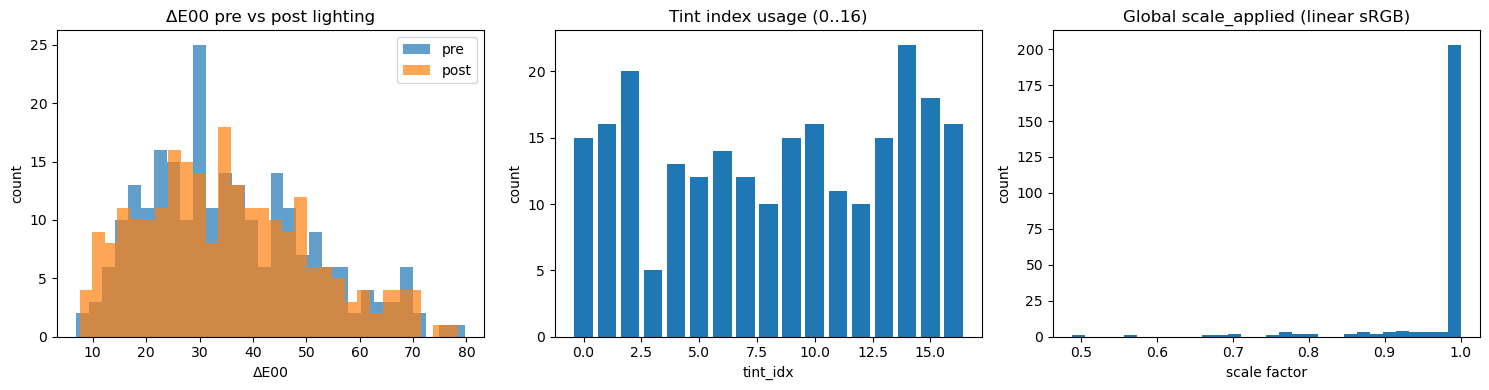

flower2_n17_s140_rot+31_dx+09_dy+07__obj[10RP-6-4]__bg[5YR-9-2]__tint13.png


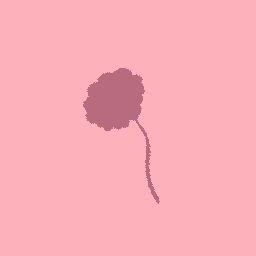

flower2_n06_s169_rot+44_dx+01_dy+15__obj[5R-4-6]__bg[2.5G-4-2]__tint14.png


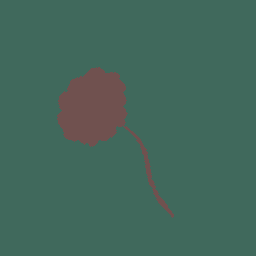

apple3_n10_s182_rot-38_dx+06_dy-06__obj[7.5B-6-10]__bg[2.5P-7-2]__tint14.png


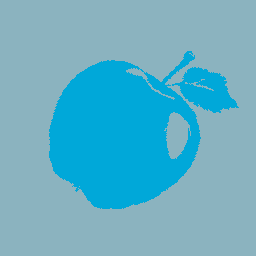

face3_n03_s144_rot+17_dx+10_dy+07__obj[10Y-6-2]__bg[5P-3-2]__tint00.png


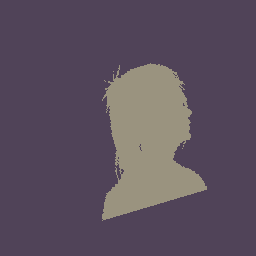

flower1_n20_s188_rot-31_dx-07_dy+06__obj[10Y-2-2]__bg[5P-3-2]__tint09.png


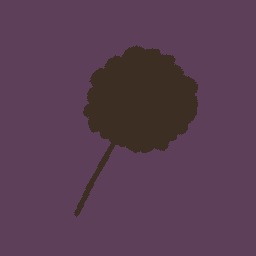

face1_n17_s142_rot+08_dx-02_dy-05__obj[10PB-8-8]__bg[2.5G-5-2]__tint14.png


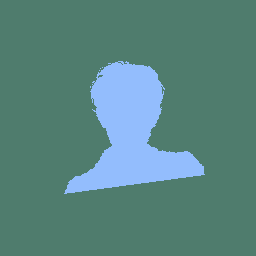

In [17]:
# Cell 6 — QC & quick previews

import pandas as pd
from IPython.display import display
import random

LOG_PATH = OUT_DIR / "colouring_log.csv"
assert LOG_PATH.exists(), f"Log not found: {LOG_PATH}"

df = pd.read_csv(LOG_PATH)

print(f"Rows in log: {len(df)}")
print(f"BACKGROUND_MODE: {df['BACKGROUND_MODE'].iloc[0] if len(df) else '(n/a)'}")
print(f"RENORM_Y: {df['RENORM_Y'].iloc[0] if len(df) else '(n/a)'}")
print(f"L0: {df['L0'].iloc[0] if len(df) else '(n/a)'}")

# Any ΔE violations post-lighting?
viol = df[df["dE_post"] < DE_MIN]
print(f"ΔE00 post-lighting < {DE_MIN}: {len(viol)} rows")
if not viol.empty:
    display(viol.head(10))

# --- Plots ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1) ΔE pre/post histograms
axes[0].hist(df["dE_pre"], bins=30, alpha=0.7, label="pre")
axes[0].hist(df["dE_post"], bins=30, alpha=0.7, label="post")
axes[0].set_title("ΔE00 pre vs post lighting")
axes[0].set_xlabel("ΔE00")
axes[0].set_ylabel("count")
axes[0].legend()

# 2) Tint usage (17 bars)
axes[1].bar(sorted(df["tint_idx"].unique()), df["tint_idx"].value_counts().sort_index().values)
axes[1].set_title("Tint index usage (0..16)")
axes[1].set_xlabel("tint_idx")
axes[1].set_ylabel("count")

# 3) Headroom scaling histogram (should be 1.0 most of the time)
axes[2].hist(df["scale_applied"], bins=30)
axes[2].set_title("Global scale_applied (linear sRGB)")
axes[2].set_xlabel("scale factor")
axes[2].set_ylabel("count")

plt.tight_layout()
plt.show()

# --- Show a few outputs ---
samples = random.sample(sorted(OUT_DIR.glob("*.png")), k=min(6, len(list(OUT_DIR.glob('*.png')))))
for s in samples:
    print(s.name)
    display(Image.open(s))

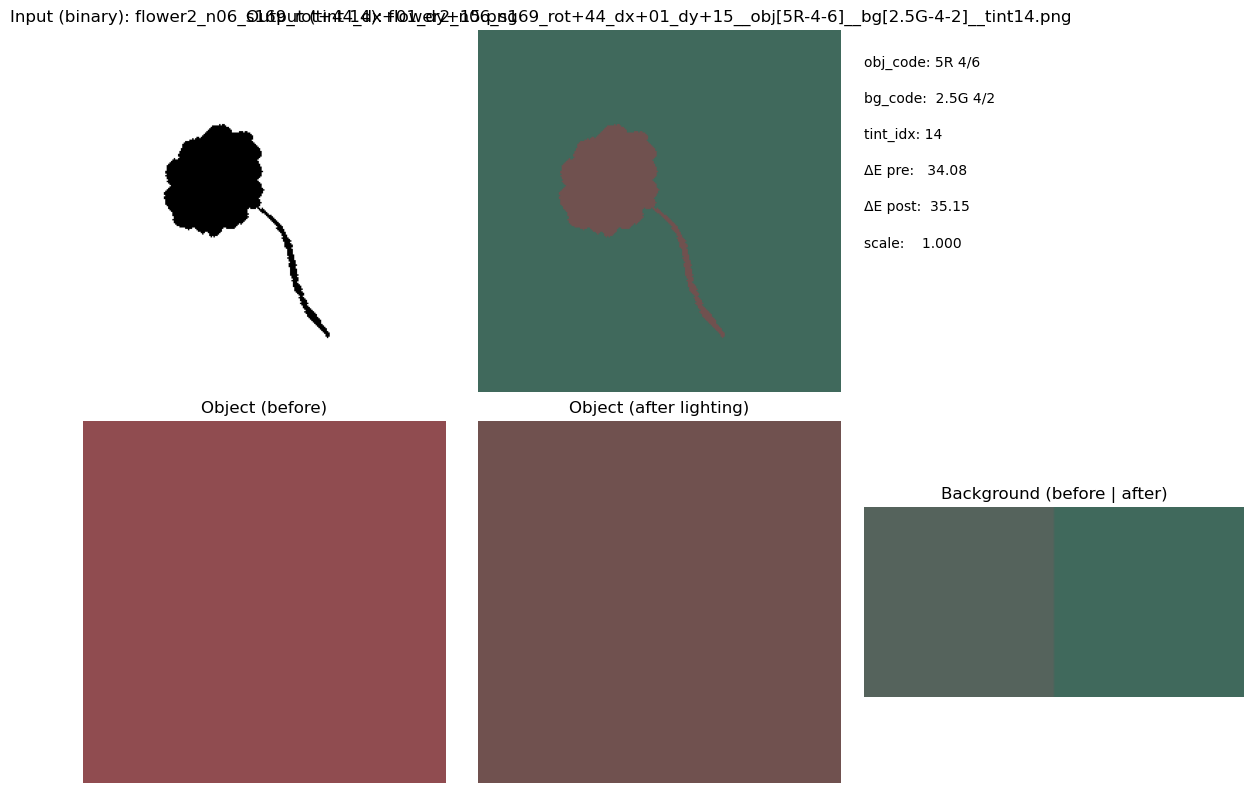

In [18]:
# Cell 7 — Preview utility: pick a row; show input/output and colour swatches pre/post lighting

def make_swatch_from_rgb_disp(rgb_disp, size=64):
    """
    rgb_disp: length-3 array in [0,1] display sRGB
    """
    arr = np.ones((size, size, 3), dtype=float)
    arr[:] = rgb_disp.reshape(1, 1, 3)
    return (arr * 255.0 + 0.5).astype(np.uint8)

def xyz_to_rgb_disp(XYZ):
    """
    XYZ -> linear sRGB -> display sRGB (clipped to [0,1]).
    """
    rgb_lin = XYZ_to_rgb_linear(XYZ)
    rgb_lin = np.clip(rgb_lin, 0.0, 1.0)
    rgb_disp = np.clip(encode_sRGB(rgb_lin), 0.0, 1.0)
    return rgb_disp

def swatch_before_after(XYZ_colour, tint_Lab, neutral_Lab):
    """
    Returns (swatch_before_u8, swatch_after_u8) as small RGB images (numpy uint8).
    """
    # before lighting
    rgb_disp_before = xyz_to_rgb_disp(np.asarray(XYZ_colour, float))

    # after lighting, using Option A
    k = lighting_multiplier_linear_sRGB(tint_Lab, neutral_Lab)
    rgb_lin_before = XYZ_to_rgb_linear(XYZ_colour)
    rgb_lin_after  = rgb_lin_before * k
    # Headroom-like clip just for swatches
    rgb_lin_after  = np.clip(rgb_lin_after, 0.0, 1.0)
    rgb_disp_after = np.clip(encode_sRGB(rgb_lin_after), 0.0, 1.0)

    return make_swatch_from_rgb_disp(rgb_disp_before), make_swatch_from_rgb_disp(rgb_disp_after)

def preview_row(idx=None):
    """
    If idx is None: pick a random row.
    Shows: input (binary), output (coloured), object/bg swatches before/after lighting.
    """
    if df.empty:
        print("No rows in log.")
        return
    if idx is None:
        idx = random.randrange(len(df))
    row = df.iloc[idx]

    in_path  = IN_DIR / row["input"]
    out_path = OUT_DIR / row["output"]
    tint_idx = int(row["tint_idx"])
    tint_Lab = LAB_TINTS[tint_idx]
    neutral  = np.array([L0, 0.0, 0.0], float)

    # Parse object/background codes, convert to XYZ
    obj_code = row["obj_code"]
    bg_code  = row["bg_code"]
    XYZ_obj  = munsell_to_XYZ(obj_code)
    XYZ_bg   = munsell_to_XYZ(bg_code)

    # swatches pre/post lighting
    sw_obj_before, sw_obj_after = swatch_before_after(XYZ_obj, tint_Lab, neutral)
    sw_bg_before,  sw_bg_after  = swatch_before_after(XYZ_bg,  tint_Lab, neutral)

    # Plot
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    # 1) input binary
    axes[0,0].imshow(Image.open(in_path))
    axes[0,0].set_title(f"Input (binary): {in_path.name}")
    axes[0,0].axis("off")

    # 2) output coloured
    axes[0,1].imshow(Image.open(out_path))
    axes[0,1].set_title(f"Output (tint {tint_idx:02d}): {out_path.name}")
    axes[0,1].axis("off")

    # 3) legend-ish panel
    axes[0,2].axis("off")
    axes[0,2].text(0.0, 0.9, f"obj_code: {obj_code}", fontsize=10)
    axes[0,2].text(0.0, 0.8, f"bg_code:  {bg_code}", fontsize=10)
    axes[0,2].text(0.0, 0.7, f"tint_idx: {tint_idx}", fontsize=10)
    axes[0,2].text(0.0, 0.6, f"ΔE pre:   {row['dE_pre']:.2f}", fontsize=10)
    axes[0,2].text(0.0, 0.5, f"ΔE post:  {row['dE_post']:.2f}", fontsize=10)
    axes[0,2].text(0.0, 0.4, f"scale:    {row['scale_applied']:.3f}", fontsize=10)

    # 4) object swatches
    axes[1,0].imshow(sw_obj_before)
    axes[1,0].set_title("Object (before)")
    axes[1,0].axis("off")

    axes[1,1].imshow(sw_obj_after)
    axes[1,1].set_title("Object (after lighting)")
    axes[1,1].axis("off")

    # 5) background swatches
    axes[1,2].imshow(np.hstack([sw_bg_before, sw_bg_after]))
    axes[1,2].set_title("Background (before | after)")
    axes[1,2].axis("off")

    plt.tight_layout()
    plt.show()

# Try a random preview:
preview_row()

In [19]:
# Cell 8 — optional toggles for a second pass (e.g., full background pool or CAT02 lighting)
# Example: switch to full background pool and write to a new folder.

BACKGROUND_MODE = "full"  # switched from 'desat' to 'full'
OUT_DIR_2 = Path("/Users/kate/Documents/retina-model/Image-set-1/colored-images-fullBG")
OUT_DIR_2.mkdir(parents=True, exist_ok=True)

# Re-run just the main loop but targeting OUT_DIR_2
# (Copy-paste of the Cell 5 core, minimal changes to output path and log name)

NEUTRAL_LAB = np.array([L0, 0.0, 0.0], float)

log_rows_2 = []
saved_2 = 0
pngs = sorted(IN_DIR.glob("*.png"))
print(f"[fullBG] Found {len(pngs)} input PNGs in {IN_DIR}")

for p in pngs:
    (obj_code, XYZ_obj, Lab_obj), (bg_code, XYZ_bg, Lab_bg), dE_pre = pick_object_and_background()
    M = load_binary_mask(p)
    XYZ_base = build_XYZ_base(M, XYZ_obj, XYZ_bg)

    import random
    tint_idx = random.randrange(len(LAB_TINTS))
    tint_Lab = LAB_TINTS[tint_idx]

    Lab_obj_after = lab_after_optionA_for_XYZ_colour(XYZ_obj, tint_Lab, NEUTRAL_LAB)
    bg_code_final, XYZ_bg_final, Lab_bg_final, Lab_bg_after, dE_post = nudge_background_postlighting(
        Lab_obj_after, tint_Lab, NEUTRAL_LAB, bg_code, XYZ_bg, Lab_bg
    )
    if bg_code_final != bg_code:
        XYZ_base = build_XYZ_base(M, XYZ_obj, XYZ_bg_final)

    RGB_lin = apply_uniform_lighting_linear_sRGB(XYZ_base, tint_Lab, NEUTRAL_LAB)
    max_lin = float(np.max(RGB_lin))
    scale_applied = 1.0
    if max_lin > 1.0:
        scale_applied = 0.98 / (max_lin + 1e-12)
        RGB_lin = RGB_lin * scale_applied

    RGB_disp = np.clip(encode_sRGB(np.clip(RGB_lin, 0.0, 1.0)), 0.0, 1.0)
    out_u8 = (RGB_disp * 255.0 + 0.5).astype(np.uint8)
    out_img = Image.fromarray(out_u8)

    obj_tag = safe_tag(obj_code)
    bg_tag  = safe_tag(bg_code_final)
    out_name = f"{p.stem}__obj[{obj_tag}]__bg[{bg_tag}]__tint{tint_idx:02d}.png"
    out_path = OUT_DIR_2 / out_name
    out_img.save(out_path, "PNG")
    saved_2 += 1

    log_rows_2.append({
        "input": str(p.name),
        "output": str(out_path.name),
        "obj_code": obj_code,
        "bg_code": bg_code_final,
        "tint_idx": tint_idx,
        "dE_pre": dE_pre,
        "dE_post": dE_post,
        "scale_applied": scale_applied,
        "RENORM_Y": RENORM_Y,
        "L0": L0,
        "BACKGROUND_MODE": BACKGROUND_MODE,
    })

print(f"[fullBG] Saved {saved_2} coloured PNGs to: {OUT_DIR_2}")

log_path_2 = OUT_DIR_2 / "colouring_log.csv"
if log_rows_2:
    from csv import DictWriter
    with open(log_path_2, "w", newline="") as f:
        w = DictWriter(f, fieldnames=list(log_rows_2[0].keys()))
        w.writeheader()
        for r in log_rows_2:
            w.writerow(r)
    print(f"[fullBG] Wrote log: {log_path_2}")

[fullBG] Found 240 input PNGs in /Users/kate/Documents/retina-model/Image-set-1/transformed-images
[fullBG] Saved 240 coloured PNGs to: /Users/kate/Documents/retina-model/Image-set-1/colored-images-fullBG
[fullBG] Wrote log: /Users/kate/Documents/retina-model/Image-set-1/colored-images-fullBG/colouring_log.csv


/Users/kate
